In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print("V100 is three times faster than P100")
  print(gpu_info)

V100 is three times faster than P100
Fri Jan 15 15:43:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                   

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_USERNAME'] = "haodong1997"
os.environ['KAGGLE_KEY'] = "f31c6aa3982c597ae202acc8a1427559"

!pip install --upgrade --force-reinstall --no-deps kaggle

# Download the dataset.zip into the current run time. (Check /content, it should be there)
!kaggle competitions download -c histopathologic-cancer-detection

!cp /content/histopathologic-cancer-detection.zip /content/
# !rm -r /content/test
!mkdir -p /content/test/folder

!unzip -qq /content/histopathologic-cancer-detection.zip "test/*" -d /content/test/folder

# Download the filtered data
! curl -L --output data.zip https://www.dropbox.com/s/qjkr9fxxe3bnw68/data_noCrop.zip?dl=1
! unzip -qq /content/data.zip

Mounted at /content/drive
     |████████████████████████████████| 61kB 6.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=560532fc38aa451193bf76f686418555132b8084948af79468ae0a1ae86e07a3
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
100% 6.28G/6.31G [01:32<00:00, 62.1MB/s]
100% 6.31G/6.31G [01:32<00:00, 73.3MB/s]
cp: '/content/histopathologic-cancer-detection.zip' and '/content/histopathologic-cancer-detection.zip' are the same file
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--

In [ ]:
# !unzip -qq /content/data.zip
# https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch
# https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
import matplotlib.patches as patches
import cv2
from pathlib import Path #Needed for correct pathing with different operating systems

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from copy import deepcopy
from fastai.vision import *
from torchvision.models import *

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)   # Change it 0.4.0 if problem

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
# !pip install torch==1.2.0 torchvision==0.4.0

# Parameters

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 256

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
# feature_extract = True

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#Initialize Model

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

# Datast Loading

Initializing Datasets and Dataloaders...
Initialization Done!
torch.Size([3, 224, 224])
torch.Size([256, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


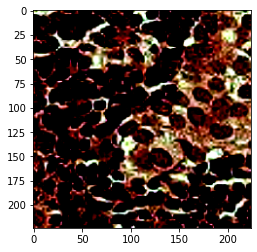

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

# For imaging
rgb_channels_mean = [0.702447, 0.546243, 0.696453]
rgb_channels_SD = [0.238893, 0.282094, 0.216251]


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(rgb_channels_mean, rgb_channels_SD)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(rgb_channels_mean, rgb_channels_SD)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(rgb_channels_mean, rgb_channels_SD)
    ]),
}

# data --> trans --> model
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets dictionary
data_dir = "/content/data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders dictionary
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Test dataset and loader
test_dir = "/content/test/folder"
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transforms["test"])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Initialization Done!")

for i , (data, labels) in enumerate(image_datasets['train']):
    print(data.shape)
    break

for i , (data, labels) in enumerate(test_dataloader):
    print(data.shape)
    break

plt.imshow(test_dataset[0][0].permute(1, 2, 0))

# plt.imshow(image_datasets['train'][0][0].permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


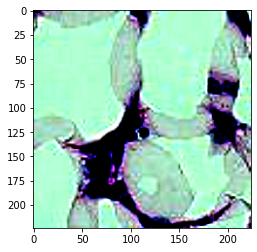

In [ ]:
plt.imshow(image_datasets['val'][0][0].permute(1, 2, 0))

# Training & evaluation function 

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print("current learning:", get_lr(optimizer))
        print('-' * 20)     

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            true_labels = np.array([])
            probs = np.array([])
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss # Special case for inception
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                
                true_labels = np.append(true_labels, labels.cpu())
                probs = np.append(probs, outputs[:,-1].cpu().detach().numpy())
            
            auc_scores = roc_auc_score(true_labels , probs) 
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("AUC score: {}".format(auc_scores), "\n")
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("New best acc! Save model")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print("Used time: {}".format(str((time.time() - start_time)/60) + " min"))

        # if auc_scores > 0.96:
        #     torch.save({'model_state_dict': model.state_dict(),
        #             'optimizer_state_dict': optimizer.state_dict(),
        #             'scheduler_state_dict' : scheduler.state_dict(),
        #             }, "/content/drive/MyDrive/Comp_Medicine/Model/Resnet18_HVflip_better"+str(epoch))
        #     print("auc_scores > 0.96, model saved")

        torch.cuda.empty_cache()
        del inputs
        del labels
        del loss
        scheduler.step()
        print()

    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m'.format(time_elapsed / 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

# Optimizer, scheduler, criterion

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

#  Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
# print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            # print("\t",name)
            continue

# Observe that all parameters are being optimized
learningRate = 0.01
weightDecay = 5e-5
momentum=0.9
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, weight_decay=weightDecay, momentum=momentum)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.85)

criterion = nn.CrossEntropyLoss()

#Model training and evaluate


In [ ]:
model_out, val_acc_history, val_loss_history = train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/19
current learning: 0.001
--------------------
train Loss: 0.2321 Accuracy: 0.9060
AUC score: 0.9591296078038859 

val Loss: 0.1696 Accuracy: 0.9370
AUC score: 0.9776353060120193 

New best acc! Save model
Used time: 4.949514492352804 min

Epoch 1/19
current learning: 0.001
--------------------
train Loss: 0.1591 Accuracy: 0.9410
AUC score: 0.980679618077209 

val Loss: 0.1448 Accuracy: 0.9481
AUC score: 0.9838437067376465 

New best acc! Save model
Used time: 4.848533328374227 min

Epoch 2/19
current learning: 0.001
--------------------
train Loss: 0.1388 Accuracy: 0.9489
AUC score: 0.985309580264181 

val Loss: 0.1307 Accuracy: 0.9529
AUC score: 0.9866807487742447 

New best acc! Save model
Used time: 4.8496542056401575 min

Epoch 3/19
current learning: 0.00085
--------------------
train Loss: 0.1252 Accuracy: 0.9545
AUC score: 0.9879644910900869 

val Loss: 0.1222 Accuracy: 0.9567
AUC score: 0.9890132491900572 

New best acc! Save model
Used time: 4.986080054442088 min

Epo

In [ ]:
# plt.plot(val_acc_history, label = "val_acc")
# plt.plot(val_loss_history, label = "val_loss")
# plt.xlabel("training epoch")
# plt.legend()

# !mkdir /content/drive/MyDrive/Comp_Medicine/output_fig/
# dir = "/content/drive/MyDrive/Comp_Medicine/output_fig/"
# plt.savefig(dir + "resnet_HVflip.jpg")

# plt.show()

model = model_out
torch.save({'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(),
        }, "/content/drive/MyDrive/CMU Course/Comp_Medicine/Model/Resnet18_whole_image_no_elimination")
# print("auc_scores > 0.96, model saved")

#Testing funtion

In [ ]:
def test_classify(model, test_loader):
    model.eval()
    probs_list = []
    with torch.no_grad():
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats).cpu()

            # Extract prob
            probs = outputs[:,1].detach().cpu().numpy()
            probs_list.extend(probs)
            del feats
            del labels
    return probs_list

# Testing and generate probability

In [ ]:
from sklearn import metrics

def infer(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    probs = []
    true_labels = []

    with torch.no_grad():
        for inputs,labels in loader:
            inputs = inputs.float().to(device)
            labels = labels.long()
            outputs = model(inputs).cpu()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            # print(outputs)
            # print(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs.extend(outputs.detach().numpy())
            true_labels.extend(labels.detach().numpy())

    acc = correct / total
    avg_loss = running_loss / total
    return avg_loss, acc, probs, true_labels

# avg_loss, acc, probs, true_labels = infer(model_ft, dataloaders_dict["val"], criterion, device)
avg_loss, acc, probs, true_labels = infer(model_out, dataloaders_dict["val"], criterion, device)


probs = np.array(probs)
mod = np.array(probs[:,1])
true_labels = np.array(true_labels)

# Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(true_labels , mod )

# Compute ROC area
# roc_auc = auc(fpr, tpr)
# print('ROC area is {0}'.format(roc_auc))

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")

# plt.savefig(dir + "resnet_HVflip_AUC.jpg")

In [ ]:
!unzip -qq /content/histopathologic-cancer-detection.zip "sample_submission.csv" -d /content/


# ID taken in order in test folder
ids = [name[0].split(".tif")[0].split("/")[-1] for name in test_dataset.imgs]

order_ids = []
with open("/content/sample_submission.csv", "r") as w:
    w.readline()
    for line in w:
        id = line.split(",")[0]
        order_ids.append(id)
       
# model_load, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=True)
# checkpoint = torch.load("/content/drive/MyDrive/Comp_Medicine/Model/Resnet18_HVflip2")
# model_load.load_state_dict(checkpoint["model_state_dict"])
# model_load.to(device)

# probs = test_classify(model_ft, test_dataloader)
probs = test_classify(model_out, test_dataloader)


with open("/content/submit_hvflip.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(order_ids)):
        id = order_ids[i]
        index = ids.index(id)
        f.write(ids[index] + "," + str(probs[index]) + "\n" )

In [ ]:
# !less /content/drive/MyDrive/Comp_Medicine/submit_final.csv
! kaggle competitions submit -c histopathologic-cancer-detection -f "/content/submit_hvflip.csv" -m "Use the whole image"

100% 2.82M/2.82M [00:04<00:00, 624kB/s]
Successfully submitted to Histopathologic Cancer Detection